In [2]:
import torch
import sys
import os
import time
import numpy as np
import argparse

from torch.utils.data import DataLoader
from torch.utils.data import WeightedRandomSampler
from umap.umap_ import find_ab_params

from singleVis.custom_weighted_random_sampler import CustomWeightedRandomSampler
from singleVis.SingleVisualizationModel import VisModel
from singleVis.losses import UmapLoss, ReconstructionLoss, SingleVisLoss
from singleVis.edge_dataset import DataHandler
from singleVis.trainer import SingleVisTrainer
from singleVis.data import NormalDataProvider
from singleVis.spatial_edge_constructor import kcSpatialAlignmentEdgeConstructor
# from singleVis.temporal_edge_constructor import GlobalTemporalEdgeConstructor
from singleVis.alignment_edge_constructor import LocalAlignmentEdgeConstructor
from singleVis.projector import TimeVisProjector
from singleVis.eval.evaluator import Evaluator


import torch
import numpy as np
from CKA import CKA, CudaCKA

/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
CONTENT_PATH = "/home/yifan/dataset/noisy/pairflip/cifar10/0/"
REF_PATH = "/home/yifan/dataset/noisy/pairflip/cifar10/reference/"
NOISY20 = "/home/yifan/dataset/noisy/pairflip/cifar10/20/"
sys.path.append(REF_PATH)
sys.path.append(CONTENT_PATH)

from config import config

SETTING = config["SETTING"]
CLASSES = config["CLASSES"]
DATASET = config["DATASET"]
GPU_ID = config["GPU"]
EPOCH_START = config["EPOCH_START"]
EPOCH_END = config["EPOCH_END"]
EPOCH_PERIOD = config["EPOCH_PERIOD"]

# Training parameter (subject model)
TRAINING_PARAMETER = config["TRAINING"]
NET = TRAINING_PARAMETER["NET"]
LEN = TRAINING_PARAMETER["train_num"]

# Training parameter (visualization model)
VISUALIZATION_PARAMETER = config["VISUALIZATION"]
PREPROCESS = VISUALIZATION_PARAMETER["PREPROCESS"]
LAMBDA = VISUALIZATION_PARAMETER["LAMBDA"]
B_N_EPOCHS = VISUALIZATION_PARAMETER["BOUNDARY"]["B_N_EPOCHS"]
L_BOUND = VISUALIZATION_PARAMETER["BOUNDARY"]["L_BOUND"]
INIT_NUM = VISUALIZATION_PARAMETER["INIT_NUM"]
ALPHA = VISUALIZATION_PARAMETER["ALPHA"]
BETA = VISUALIZATION_PARAMETER["BETA"]
MAX_HAUSDORFF = VISUALIZATION_PARAMETER["MAX_HAUSDORFF"]
# HIDDEN_LAYER = VISUALIZATION_PARAMETER["HIDDEN_LAYER"]
ENCODER_DIMS = VISUALIZATION_PARAMETER["ENCODER_DIMS"]
DECODER_DIMS = VISUALIZATION_PARAMETER["DECODER_DIMS"]
S_N_EPOCHS = VISUALIZATION_PARAMETER["S_N_EPOCHS"]
T_N_EPOCHS = VISUALIZATION_PARAMETER["T_N_EPOCHS"]
N_NEIGHBORS = VISUALIZATION_PARAMETER["N_NEIGHBORS"]
PATIENT = VISUALIZATION_PARAMETER["PATIENT"]
MAX_EPOCH = VISUALIZATION_PARAMETER["MAX_EPOCH"]

VIS_MODEL_NAME = 'vis'
EVALUATION_NAME = VISUALIZATION_PARAMETER["EVALUATION_NAME"]

SEGMENTS = [(EPOCH_START, EPOCH_END)]
# define hyperparameters
DEVICE = torch.device("cuda:{}".format(GPU_ID) if torch.cuda.is_available() else "cpu")

import Model.model as subject_model
net = eval("subject_model.{}()".format(NET))


from config import config

ref_provider = NormalDataProvider(REF_PATH, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, split=-1, device=DEVICE, classes=CLASSES,verbose=1)

data_provider = NormalDataProvider(CONTENT_PATH, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, split=-1, device=DEVICE, classes=CLASSES,verbose=1)
# REFERENCE
noisy_data_provider = NormalDataProvider(NOISY20,net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, split=-1, device=DEVICE, classes=CLASSES,verbose=1 )
ref_train_data = ref_provider.train_representation(200).squeeze()

# EPOCH 200
train_data = data_provider.train_representation(200).squeeze()
# EPOCH 199
prev_train_data = data_provider.train_representation(199).squeeze()

noisy_data = noisy_data_provider.train_representation(200).squeeze()

Finish initialization...
Finish initialization...
Finish initialization...


In [3]:
# import numpy as np
# from sklearn.cross_decomposition import CCA
# # 建立模型
# X = ref_train_data
# Y = train_data
# cca = CCA(n_components=1)
# # 训练数据
# cca.fit(X, Y)
# # print(X)
# X_train_r, Y_train_r = cca.transform(X, Y)
# # print(X_train_r)
# print('noisy20  epoch 1 vs epoch200 ')
# print(np.corrcoef(X_train_r[:, 0], Y_train_r[:, 0])[0, 1]) #输出相关系数

In [4]:
# from numpy import random
# n_dimension = train_data.shape[1]
# init_A = random.random(size=(n_dimension,n_dimension))
# ref_after =  np.dot(ref_train_data, init_A)
# print(ref_after.shape)

In [5]:
# cca = CCA(n_components=1)
# # 训练数据
# cca.fit(X, Y2)
# # print(X)
# X_train_r, Y_train_r = cca.transform(X, Y2)
# # print(X_train_r)

# print(np.corrcoef(X_train_r[:, 0], Y_train_r[:, 0])[0, 1]) #输出相关系数


In [4]:
import sympy as sp
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
# projector.batch_project(200, train_data)
l = projector.batch_project


In [26]:
from torch import nn


import scipy
import numpy as np
from sklearn.cross_decomposition import CCA

now = time.strftime("%Y-%m-%d-%H_%M_%S", time.localtime(time.time())) 
sys.stdout = open(os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/transformation_res", now+".txt"), "w")
# projector = TimeVisProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")



# Step1: Computing the loss 
def compute_loss(X,Y,R):
    '''
     The loss function will be the squared Frobenoius norm of the difference between the matrix and its approximation, divided by the number of training examples m
    Inputs:
        X: a matrix of dimension (m,n) where the colums are the contrast representation 
        Y: a matrix of dimension (m,n) where the colums are the reference representation
        R: a matrix of dimension (n,n) - transformation matrix from Y2d to X2d
    Outputs:
        L: a matrix of dimension (m,n) -the value of the loss function for given X, Y and R
    '''
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    m = len(X)
    Xnew = np.dot(X, R)
    # Ynew = np.dot(Y, R)
    # diff is Projector(XR) - Projector(Y) 
    Y_2d = projector.batch_project(200, Y)
    X_2d = projector.batch_project(200, Xnew)
    Euclid = 0
    for i in range(m):
        d = ((X_2d[i][0] - Y_2d[i][0])**2 + (X_2d[i][1] - Y_2d[i][1])**2)**0.5
        Euclid = Euclid + d
    
    print('Euclid',Euclid/m)
    

    # Xnew = np.dot(X, R)

    # print("Euclid:",np.sqrt(np.sum(np.square(projector.batch_project(200, Y)-projector.batch_project(200, np.dot(X, R))))))
    # print("Euclid:",np.sqrt(np.sum(np.square(projector.batch_project(200, Y)-projector.batch_project(200, np.dot(X, R))))))
    diff = projector.batch_project(00, np.dot(X, R)) - projector.batch_project(200, Y)

    # diff_squared is the element-wise square of the difference
    diff_squared = diff**2

    # sum_diff_squared is the sum of the squared elements
    sum_diff_squared = diff_squared.sum()

    # loss is the sum_diff_squared divided by the number of examples (m)
    loss = sum_diff_squared/m
    ### END CODE HERE ###
    return loss


# Step2: Computing the loss 
def compute_gradient(X, Y, R):
    '''
        the gradient of the loss with respect to the matrix encodes how much a tiny change 
    in some coordinate of that matrix affect the change of loss function.
        Gradient descent uses that information to iteratively change matrix R until we reach 
    a point where the loss is minimized.
    Inputs: 
        X: a matrix of dimension (m,n) where the colums are the contrast representation 
        Y: a matrix of dimension (m,n) where the colums are the reference representation
        R: a matrix of dimension (n,n) - transformation matrix from Y2d to X2d
    Outputs:
       g: a matrix of dimension (n,n) - gradient of the loss function L for given X, Y and R.
    '''
    # m is the number of rows in X
    m = len(X)
    Xnew = np.dot(X, R)


    Y_2d = projector.batch_project(200, Y)
    X_2d = projector.batch_project(200, Xnew)
    rows, columns = X.shape

    Euclid = 0
    for i in range(m):
        d = ((X_2d[i][0] - Y_2d[i][0])**2 + (X_2d[i][1] - Y_2d[i][1])**2)**0.5
        Euclid = Euclid + d
    
    print('Euclid',Euclid/m)

    inv_X = projector.batch_inverse(200, X_2d)
    inv_Y = projector.batch_inverse(200, Y_2d)
    # gradient is X^T(XR - Y) * 2/m
    # gradient = (np.dot(inv_X.T, np.dot(inv_X, R) - inv_Y))/rows
    gradient = (np.dot(X.T, np.dot(X, R) - Y) * 2)/rows
    assert gradient.shape == (columns, columns)
    ### END CODE HERE ###
    return gradient



# Most of the time we iterate for a fixed number of training steps rather than iterating until the loss falls below a threshold.

# 1.Calculate gradient g of the loss with respect to the matrix R. 
# 2. Update R (Rnew = Rold - αg) . α is the learning rate which is a scalar.

# alignment_embeddings
def align_embeddings(X: np.ndarray, Y: np.ndarray,
                      train_steps: int=1000,
                      learning_rate: float=0.0003,
                      seed: int=129) -> np.ndarray:
    '''
    Finding the optimal R with gradient descent algorithm
    Inputs:
        X: a matrix of dimension (m,n) where the colums are the contrast representation 
        Y: a matrix of dimension (m,n) where the colums are the reference representation
        train_steps: positive int - describes how many steps will gradient descent algorithm do.
        learning_rate: positive float - describes how big steps will  gradient descent algorithm do.
    Outputs:
        R: a matrix of dimension (n,n) - the projection matrix that minimizes the F norm ||projector(X R) - projector ( Y )||^2
    '''
    # the number of columns in X is the number of dimensions for a word vector (e.g. 300)
    # R is a square matrix with length equal to the number of dimensions in th  word embedding
    R = np.random.rand(X.shape[1], X.shape[1])

    for i in range(train_steps):
        if i % 5 == 0:
            print(f"loss at iteration {i} is: {compute_loss(X, Y, R):.4f}")
        ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
        # use the function that you defined to compute the gradient
        gradient = compute_gradient(X, Y, R)

         # update R by subtracting the learning rate times gradient
        R -= learning_rate * gradient
        ### END CODE HERE ###
    
    return R

np.random.seed(129)
m = 10
n = 5
X = ref_train_data
Y = train_data
R = align_embeddings(X, Y)
print(R)


Euclid 62.141397741757146
loss at iteration 0 is: 3976.1280
Euclid 62.141397741757146
Euclid 48.22589007738135
Euclid 37.41349381496439
Euclid 29.01676927407011
Euclid 22.502330076105032
Euclid 17.458476240711402
loss at iteration 5 is: 322.4104
Euclid 17.458476240711402
Euclid 13.567837984952009
Euclid 10.591221314239593
Euclid 8.389035802705624
Euclid 6.8834167015527115
Euclid 5.9253949567123865
loss at iteration 10 is: 44.7621
Euclid 5.9253949567123865
Euclid 5.3422947683850115
Euclid 5.084110815263094
Euclid 5.062991989336404
Euclid 5.086405409546176
Euclid 5.138584231944622
loss at iteration 15 is: 32.7714
Euclid 5.138584231944622
Euclid 5.296680328257914
Euclid 5.445073020208438
Euclid 5.567086917998857
Euclid 5.650078945124941
Euclid 5.719927299275833
loss at iteration 20 is: 40.4965
Euclid 5.719927299275833
Euclid 5.778286354395987
Euclid 5.816388525332541
Euclid 5.823422182548549
Euclid 5.823623686868599
Euclid 5.817102009276375
loss at iteration 25 is: 41.8148
Euclid 5.817102

In [4]:
import numpy as np
from sklearn.cross_decomposition import CCA
# 建立模型
X = np.dot(ref_train_data,R)
Y = ref_train_data
cca = CCA(n_components=1)
# 训练数据
cca.fit(X, Y)
# print(X)
X_train_r, Y_train_r = cca.transform(X, Y)
# print(X_train_r)
print('noisy20  epoch 1 vs epoch200 ')
print(np.corrcoef(X_train_r[:, 0], Y_train_r[:, 0])[0, 1]) #输出相关系数

NameError: name 'R' is not defined

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 598.75it/s]


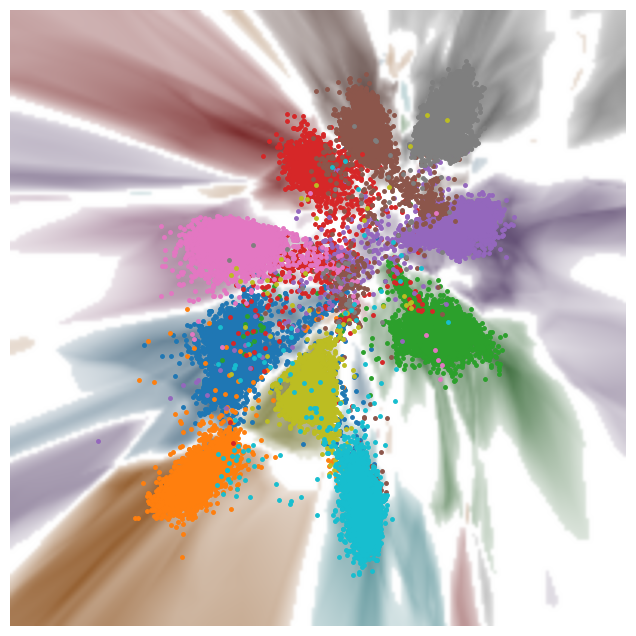

In [12]:
from singleVis.rep_visualizer import visualizer
vis = visualizer(data_provider, train_data, projector, 200, 'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 608.63it/s]


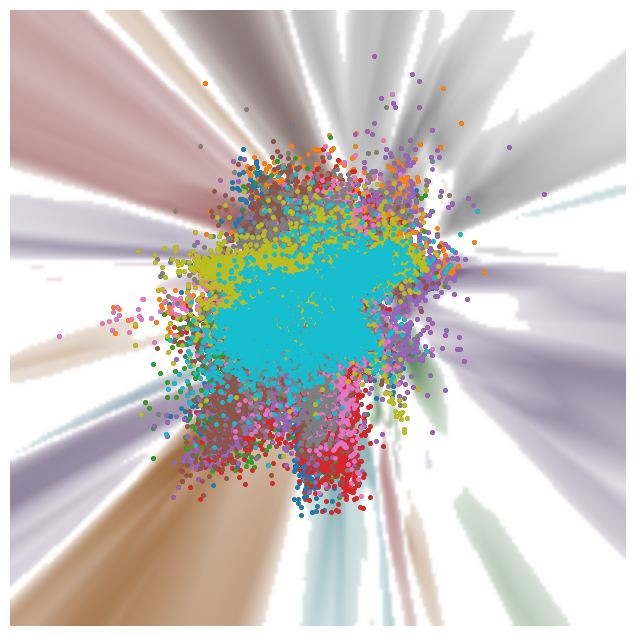

In [23]:
from singleVis.rep_visualizer import visualizer
vis = visualizer(data_provider, np.dot(train_data,R), projector, 200, 'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

In [3]:
from singleVis.rep_visualizer import visualizer
vis = visualizer(data_provider, noisy_data, projector, 200, 'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))


NameError: name 'projector' is not defined

In [5]:
from singleVis.rep_visualizer import visualizer

vis = visualizer(data_provider, np.dot(noisy_data,R), projector, 200, 'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

NameError: name 'R' is not defined

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 598.41it/s]


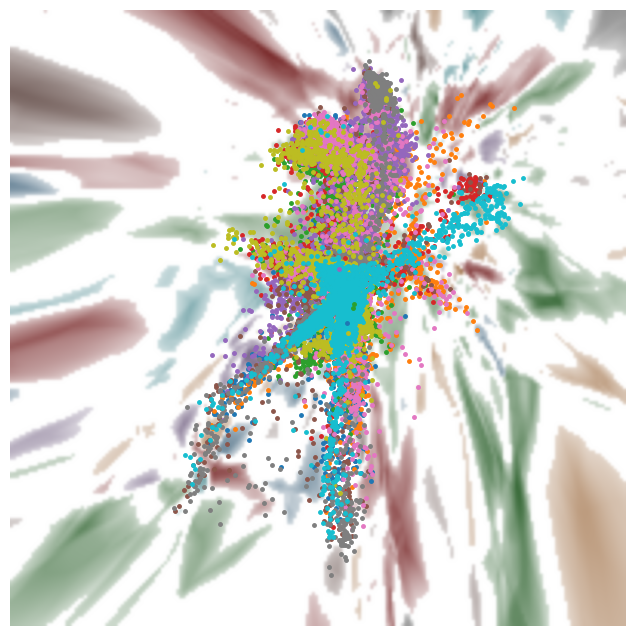

In [7]:
from singleVis.rep_visualizer import visualizer
vis = visualizer(ref_provider, ref_train_data, projector, 200, 'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "ref_contrast"))

[[ 0.01052544 -0.13037052  0.01147524 ... -0.30156212 -0.12739813
   0.37868695]
 [-0.22788565  0.36895664  0.01408691 ... -0.10419795 -0.01281763
   0.31102748]
 [-0.34090171  0.11517442  0.41302548 ... -0.02027725 -0.30505359
  -0.26512592]
 ...
 [ 0.30287786 -0.22096482 -0.1231673  ... -0.36128525 -0.10942958
   0.23685032]
 [-0.08489278 -0.13758909  0.25700675 ... -0.18708077 -0.08592307
  -0.52197578]
 [ 0.08424817 -0.43014447  0.16947329 ...  0.01023348  0.46116011
   0.09221353]]
Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 605.45it/s]


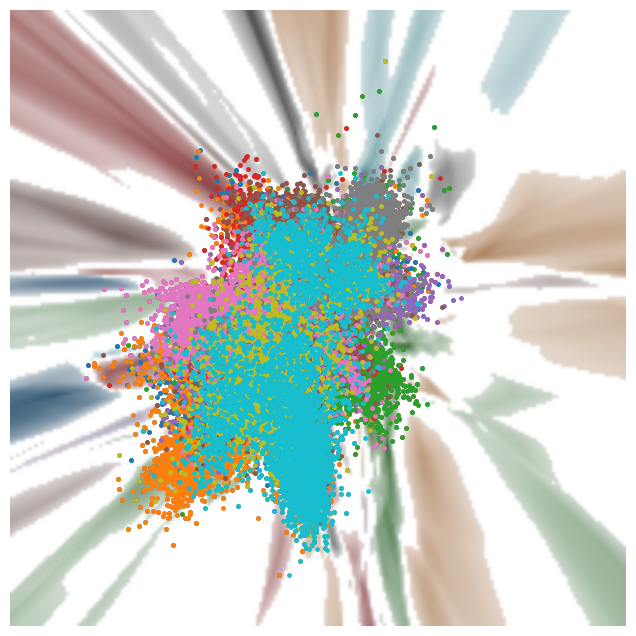

In [27]:
from singleVis.rep_visualizer import visualizer
print(R)
vis = visualizer(ref_provider, np.dot(ref_train_data, R), projector, 200, 'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "ref_contrast"))

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 604.49it/s]


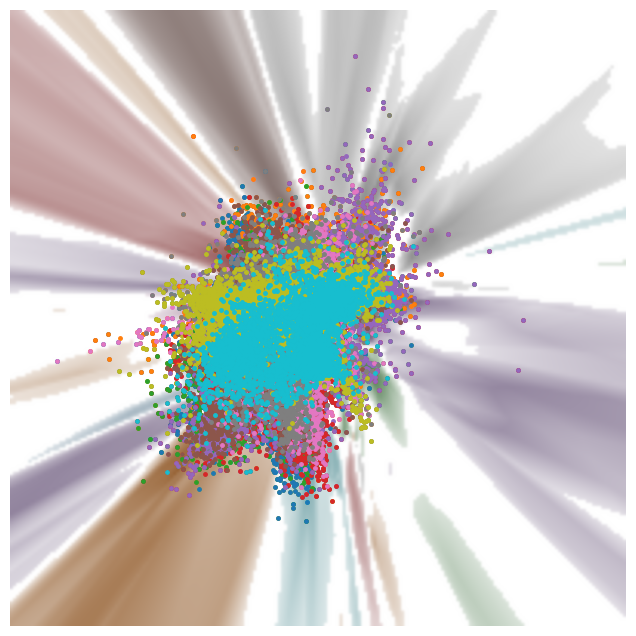

In [9]:
from singleVis.rep_visualizer import visualizer

vis = visualizer(data_provider, np.dot(train_data, R), projector, 200, 'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "ref_contrast"))

TypeError: unsupported operand type(s) for -: 'list' and 'list'